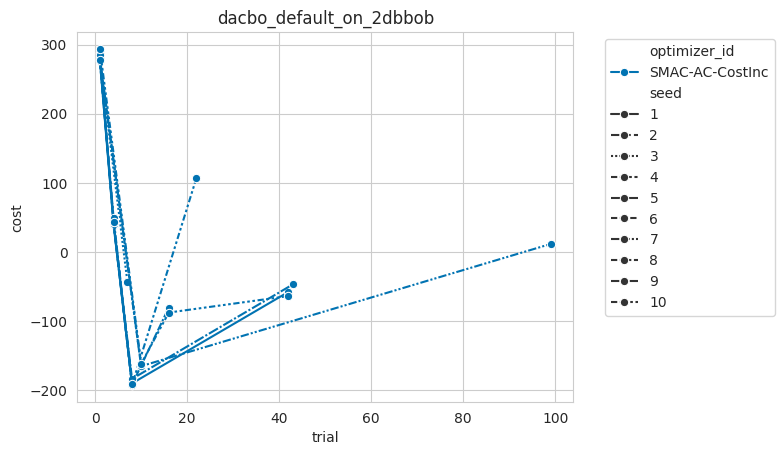

In [ ]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from carps.analysis.utils import setup_seaborn

rundir = Path("../runs/SMAC-AC-CostInc")

trajectory_df = pd.read_csv(rundir / "trajectory.csv")
configs_inc_df = pd.read_csv(rundir / "configs_inc.csv")

setup_seaborn()
for task_id, group in trajectory_df.groupby("task_id"):
    ax = sns.lineplot(data=group, x="trial", y="cost", hue="optimizer_id", style="seed", marker="o")
    ax.legend(bbox_to_anchor=(1.05, 1))
    ax.set_title(task_id)
    plt.show()